# Setting Up

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 412 (delta 133), reused 122 (delta 120), pack-reused 239
Receiving objects: 100% (412/412), 12.85 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (211/211), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-dmf187c6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-dmf187c6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=3e2a62be70ae99da5c889a73a2b9987eabc4bf5b0463183b95120221de38784f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qj7btzcv/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


In [ ]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


# Load Models

In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
SAM_ENCODER_VERSION = "vit_h"

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# Main Functions

In [ ]:
import cv2
import supervision as sv
import numpy as np
from segment_anything import SamPredictor

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

def det_and_seg(caption: str, image: np.ndarray, box_threshold: float, text_threshold: float, class_idx: int):
    detections, labels = grounding_dino_model.predict_with_caption(
        image=image,
        caption=caption,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    detections.class_id = [class_idx]*(detections.confidence.shape[0])

    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )
    return detections, labels

def main(classes: list, image: np.ndarray, box_threshold: float, text_threshold: float):
    xyxys = []
    masks = []
    confidences = []
    class_id =[]
    for i in range(len(classes)):
        caption = classes[i]
        detections_i, labels = det_and_seg(
            caption=caption,
            image=image,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            class_idx=i
        )
        xyxys.append(detections_i.xyxy)
        masks.append(detections_i.mask)
        confidences.append(detections_i.confidence)
        class_id.extend(detections_i.class_id)
    xyxy = np.vstack(xyxys)
    mask = np.vstack(masks)
    confidence = np.hstack(confidences)
    return xyxy, mask, confidence, class_id

def visualize(image: np.ndarray, classes: list, xyxy: np.ndarray, mask: np.ndarray, confidence: np.ndarray, class_id: list):
    detections = sv.Detections.empty()
    detections.xyxy = xyxy
    detections.mask = mask
    detections.confidence = confidence
    detections.class_id = class_id
    labels = [
        f"{classes[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in detections]
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    %matplotlib inline
    sv.plot_image(annotated_image, (16, 16))
    return

def read_frame_from_video(video_path: str, frame_number: int):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    return frame

# def get_mask_coordinates(mask):
#   ## Extract pixels coordinates of a single object mask
#     object_coordinates = np.argwhere(detections.mask[0])
#     return object_coordinates

# Testing Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# testing parameters

classes = ['table leg','tabletop']
BOX_TRESHOLD = 0.2
TEXT_TRESHOLD = 0.1

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


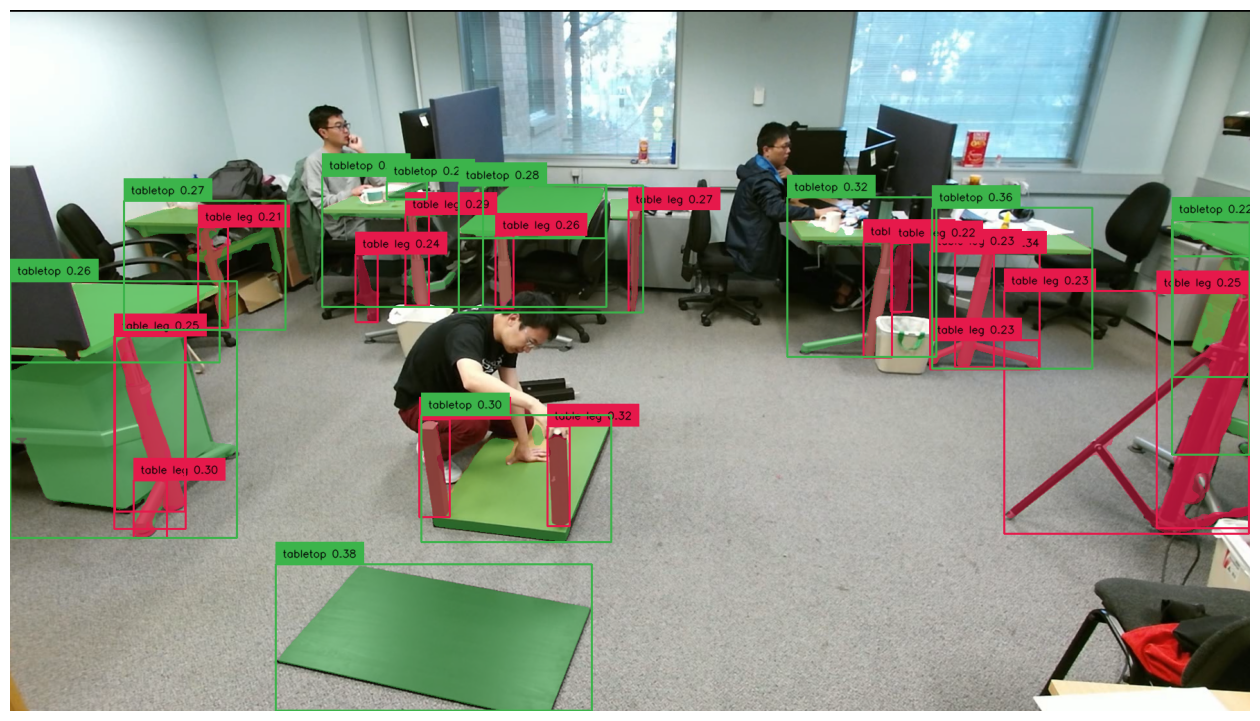

In [ ]:
# for image input

SOURCE_IMAGE_PATH = "/content/drive/MyDrive/Project/Object_tracking/video_frame_try2.png"

xyxy, mask, confidence, class_id = main(
    classes=classes,
    image=cv2.imread(SOURCE_IMAGE_PATH),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

visualize(
    image=cv2.imread(SOURCE_IMAGE_PATH),
    classes=classes,
    xyxy=xyxy,
    mask=mask,
    confidence=confidence,
    class_id=class_id)

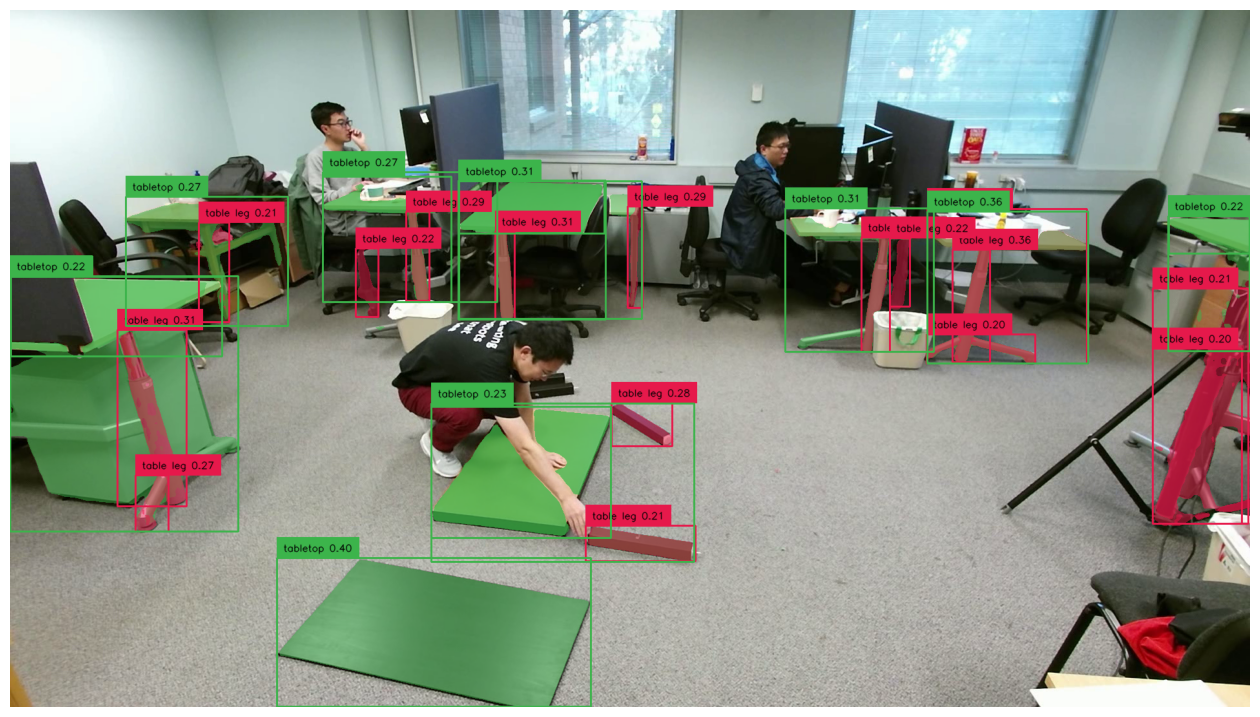

In [ ]:
# for video and frame index input

video_path = "/content/drive/MyDrive/Project/Object_tracking/scan_video.avi"
frame_number = 200
frame = read_frame_from_video(video_path=video_path, frame_number=frame_number)

xyxy, mask, confidence, class_id = main(
    classes=classes,
    image=frame,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

visualize(
    image=frame,
    classes=classes,
    xyxy=xyxy,
    mask=mask,
    confidence=confidence,
    class_id=class_id)

# Process CSV